In [904]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from skopt import BayesSearchCV
from math import sqrt
from xgboost import XGBRegressor

import warnings

# Data Import and a First Glance at the Data

As the first step, we import the Day specific data.

In [905]:
df = pd.read_csv('train.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [906]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [907]:
df.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Intuitively, I would assume that on days on which a store is closed, there will be no customer and thus no sales. If that is actually the case in the data, then we could already and very easily make 100% accurate predictions for days on which a store is closed. Therefore, we would not need to train an algorithm on this subset of the data, but simply predict 0 sales. Depending on the number of rows, removing data for closed days, could improve training time and predictive power by removing noise from the dataset.

In [908]:
df_closed = df[df['Open'] == 0]

And indeed, for the 172817 rows for closed days, we see that the sales are 0 all across the board. This is a great insight already generated!

In [909]:
df_closed.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,172817.000000,172817.000000,172817.0,172817.0,172817.0,172817.000000,172817.000000
mean,558.462987,6.333769,0.0,0.0,0.0,0.064716,0.105684
std,322.771734,1.547688,0.0,0.0,0.0,0.246025,0.307434
min,1.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000
25%,279.000000,7.000000,0.0,0.0,0.0,0.000000,0.000000
50%,560.000000,7.000000,0.0,0.0,0.0,0.000000,0.000000
75%,839.000000,7.000000,0.0,0.0,0.0,0.000000,0.000000
max,1115.000000,7.000000,0.0,0.0,0.0,1.000000,1.000000


So, let's trim our dataset to rows do not have the value 0 for the column "Open", i.e. only data for days when a store is actually open. Since we did not have any values outside of 0 and 1 in the column and the 0 have all been removed, we can now drop the invariant "Open" column.

In [910]:
df_open = df[df['Open'] != 0]
df_open = df_open.drop('Open', axis=1)

We have around 845k rows left.

In [911]:
df_open.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


Next, we import the separate csv containing store specific data and take a look at the columns and values

In [912]:
store_df = pd.read_csv('store.csv')

In [913]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Using the "Store" column as a key, we can merge the additional data to our already imported date based data. The length of the dataframe has not changed, so we should be good to continue

In [914]:
df_full = pd.merge(df_open, store_df, on='Store')
len(df_full)

844392

In [915]:
df_full.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


Some of the store based data has introduced some missing values. This is mainly due to the either the absence of data about the competition or the absence of a second promo.

In [916]:
df_full.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

For roughly 2000 missing rows about the competition distance, I decide to drop them, because they represent less than 0.25% of our entire data. Also it is a continuous variable, so I would have to impute it, if I wanted to keep the rows. But how would you impute them? Use the mean value of all columns? Use an algorithmic approach? As you can see, this would open another can of worms where the answer is not really straight forward, so let's just drop the rows.

In [917]:
df_full = df_full.dropna(subset=['CompetitionDistance'])

The other variables we will treat as categorical ones. Sure, variables such as day, week or month are actually ordinal cyclical ones, but keeping them as is will not take into account their cyclical properties. What you could possibly do is use a trigonometric approach by doing something like this:

x_month = sin(2*pi*month/12)
y_month = cos(2*pi*month/12)

But since I am not planning to use a linear regression model, just keeping them as categorical variables is just fine.

In [918]:
df_full = df_full.fillna('not available')

While we are at it, let's examine the "Promo Interval column and how many distinct values it actually has. And as we can see - despite the possibility of many permutations - it just contains 3 permutations, while roughly half of the data was missing. So leaving the variable as is and just filling the NaN with "not available" seems fine!

In [919]:
df_full['PromoInterval'].value_counts()

not available       421743
Jan,Apr,Jul,Oct     242411
Feb,May,Aug,Nov      97383
Mar,Jun,Sept,Dec     80669
Name: PromoInterval, dtype: int64

In [920]:
df_full.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

I noticed that the "StateHoliday" column basically had two "0" values. This often happens, when one of the same values has a whitespace character. So we remove it and now have only one "0" value.

In [921]:
df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [922]:
df['StateHoliday'] = df['StateHoliday'].str.strip()
df['StateHoliday'].value_counts()

0    855087
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

# Feature Engineering

Next up, we deconstruct the timestamp into its constituent parts, namely day of the month, weekday name, month and year.
Sure, we actually already have a "Day of Week" column, but for the sake of uniformity, we will drop it and replace it by the one generated from the timestamp.

In [923]:
def time_decon(df, col):
    if df[col].dtype != 'datetime64[ns]':
        df[col] = pd.to_datetime(df[col])
    df['day'] = df[col].dt.day
    df['day_name'] = df[col].dt.day_name()
    df['month'] = df[col].dt.month
    df['year'] = df[col].dt.year
    return df

In [924]:
df_full = time_decon(df_full, 'Date')

In [925]:
df_full = df_full.drop('DayOfWeek', axis=1)

In [926]:
df_full.head()

,Store,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,day_name,month,year
0,1,2015-07-31,5263,555,1,0,1,c,a,1270.0,9,2008,0,not available,not available,not available,31,Friday,7,2015
1,1,2015-07-30,5020,546,1,0,1,c,a,1270.0,9,2008,0,not available,not available,not available,30,Thursday,7,2015
2,1,2015-07-29,4782,523,1,0,1,c,a,1270.0,9,2008,0,not available,not available,not available,29,Wednesday,7,2015
3,1,2015-07-28,5011,560,1,0,1,c,a,1270.0,9,2008,0,not available,not available,not available,28,Tuesday,7,2015
4,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9,2008,0,not available,not available,not available,27,Monday,7,2015


# Outlier Detection and Removal

Outliers are a tricky topic, because oftentimes a statistical outlier might not be an outlier from a business perspective and vice versa. Outliers can often be valid, uncorrupted data, which simply represents an edge case for a business. Still, outliers can have a negative impact on a model performance, so I have chosen to remove a conservative amount using an algorithmic approach.

Please note that Isolation Forest is unsupervised, so applying it on the whole data set will not result in data leakage!

In [927]:
df_full.describe()

,Store,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,day,month,year
count,842206.000000,842206.000000,842206.000000,842206.000000,842206.000000,842206.000000,842206.00000,842206.000000,842206.000000,842206.000000
mean,558.374649,6959.338682,763.273029,0.446348,0.193595,5457.979627,0.49924,15.835710,5.846097,2013.831953
std,321.922659,3104.460543,401.383812,0.497113,0.395115,7809.437311,0.50000,8.683457,3.324006,0.777225
min,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.00000,1.000000,1.000000,2013.000000
25%,280.000000,4864.000000,519.000000,0.000000,0.000000,710.000000,0.00000,8.000000,3.000000,2013.000000
50%,557.000000,6373.000000,676.000000,0.000000,0.000000,2320.000000,0.00000,16.000000,6.000000,2014.000000
75%,837.000000,8363.000000,893.000000,1.000000,0.000000,6890.000000,1.00000,23.000000,8.000000,2014.000000
max,1115.000000,41551.000000,7388.000000,1.000000,1.000000,75860.000000,1.00000,31.000000,12.000000,2015.000000


In [928]:
def isolation_outlier(df, cols=None):
    original_len = len(df)
    print('dataset with outliers:', original_len)
    isof = IsolationForest(max_samples=1000, contamination=.05)
    if cols == None:
        isof.fit(df.select_dtypes(include=np.number))
        listpred = isof.predict(df.select_dtypes(include=np.number))
    else:
        isof.fit(df[cols])
        listpred = isof.predict(df[cols])
    df['outlier'] = listpred
    df = df.loc[df['outlier'] == 1]
    df.drop('outlier', axis=1, inplace=True)
    new_len = len(df)
    diff = original_len-new_len
    print('dataset without outliers:', new_len)
    print('percentage of data removed:', round((diff/original_len)*100, 2),'%' )
    return df

Around 5% of Outliers have been removed

In [929]:
df_full_iso = isolation_outlier(df_full, cols=['CompetitionDistance'])

dataset with outliers: 842206
dataset without outliers: 800568
percentage of data removed: 4.94 %


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Train Test Split

The sampling strategy of the data splits is often more important with regards to the model's performance than the algorithm and its hyperparameters.

First, I shuffle the the dataset, then I sort it by the date. This has the effect, that you will actually predict the "future" with the help of the "past" as it will be the case in a real-world application. Having 2015 data in the training set to predict 2013 data in the test set is illogical as this will never occur in a real world scenario. 

Sure, using this time-sensitive sampling and splitting strategy might lose us some performance "in the lab", but assures that the model generalizes better in a real-world application.

We also drop the customer column as we cannot use it for a sales prediction task as the number of customers on a given day in the future is not available to us before the number of sales.

For future reference, we can use the number of customers as target for a different prediction task or even engineer a new KPI such as "Sales per customer", which would provide insights about the customers shopping behavior.

In [930]:
df_full_iso = df_full_iso.sample(frac=1)
df_full_iso = df_full_iso.sort_values(by=['Date'])
df_full_iso = df_full_iso.drop(['Date', 'Customers'], axis=1)

In [931]:
X_train, X_test, y_train, y_test = train_test_split(df_full_iso.drop('Sales', axis=1), df_full_iso['Sales'], 
                                                    test_size=0.3, random_state=42, shuffle=False)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

After splitting the data, we plot the distribution plot of the sales column.

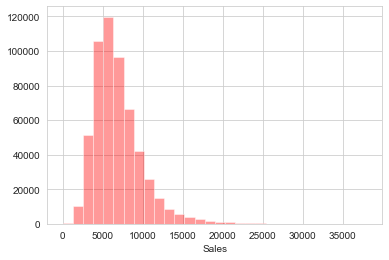

In [932]:
sns.set_style('whitegrid') 
sns.distplot(df_train['Sales'], kde = False, color ='red', bins = 30) 

In [933]:
round(df_train['Sales'].mean())

6840

We also make sure that our split has worked as intended. And it seems like it did - the training data has only 2013 and 2014 values in it.

In [934]:
df_train['year'].value_counts()

2013    320669
2014    239728
Name: year, dtype: int64

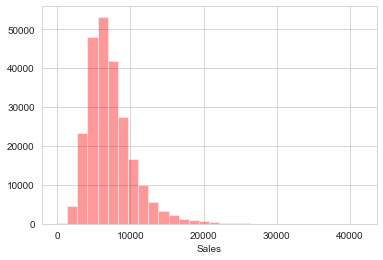

In [935]:
sns.set_style('whitegrid') 
sns.distplot(df_test['Sales'], kde = False, color ='red', bins = 30) 

Time sensitive splitting, of course, does not account for a similar distribution of the target in train and test sets. The mean number of sales in the test set is slightly higher than in the training set.

In [936]:
round(df_test['Sales'].mean())

7260

Meanwhile, the test data only contains 2014 and 2015 data

In [937]:
df_test['year'].value_counts()

2015    186005
2014     54166
Name: year, dtype: int64

# Categorical Features

Moving on to the transformation of categorical variables, we first identify the columns in need of preprocessing. Earlier I explained why I am including ordinal cyclical features like day, week, month, etc. in this. The other columns are pretty self explanatory as they are strings, which need to be transformed into a numeric representation.

In [938]:
loo_cols = ['PromoInterval', 'year', 'StoreType', 'Store', 'Assortment','CompetitionOpenSinceMonth',
            'Promo2SinceWeek', 'day_name','month', 'Promo2SinceYear', 'CompetitionOpenSinceYear','day', 'StateHoliday']

To do this, I employ a "leave one out" target encoder.

The encoded column will not result conventional dummy variable, but instead is the mean response over all rows for this categorical level, excluding the row itself. This gives you the advantage of having a one-column representation of the categorical while avoiding direct response leakage.

Given that some of the categorical columns like "Store" are very high dimensional (1000+ stores), encoding them as Dummy or One Hot features would drastically increase our dataset's dimensionality, so enconding into one column without data leakage is highly preferable for the sake of training time optimization as well as model complexity.

Training the encoder is performed exclusively on the training data.

In [939]:
loo = LeaveOneOutEncoder(cols = loo_cols, drop_invariant=True, handle_unknown='value')
loo.fit(X_train, y_train)

LeaveOneOutEncoder(cols=['PromoInterval', 'year', 'StoreType', 'Store',
                         'Assortment', 'CompetitionOpenSinceMonth',
                         'Promo2SinceWeek', 'day_name', 'month',
                         'Promo2SinceYear', 'CompetitionOpenSinceYear', 'day',
                         'StateHoliday'],
                   drop_invariant=True, handle_missing='value',
                   handle_unknown='value', random_state=None, return_df=True,
                   sigma=None, verbose=0)

You will notice that the test data is encoded based on the insights derived from the training on the training data, thus no data leakage occurs!

In [940]:
X_train = loo.transform(X_train)
X_test = loo.transform(X_test)

# Baseline: Using the Mean of the Training Dataset as our Prediction

We are done with data preprocessing. Next, we will create a naive baseline using the mean of the training set sales' column as our sole prediction value and see how we fare.

In [941]:
y_pred_mean = np.tile(y_train.mean(), len(y_test))

Quickly, we write a little function that calculates the RMSE. RMSE penalizes larger errors and is easily interpretable as it is represented in the same unit as the target variable.

In [942]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Our RMSE in this case 3189 and this is the number we have to beat in order for our model to be viable.

In [943]:
rmse_mean = rmse(y_test, y_pred_mean)
round(rmse_mean,2)

3188.74

# Hyperparameter Optimization, K-Fold cross validation and Model Training

As for the algorithm, I choose XGBoost because it is non-parametric, handles different data types well and is very robust against abnormalities in the data. In industrial application, it often performs well out of the box. 

In [944]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

After establishing a baseline, we now define a parameter space for an XGBoost Regression algorithm.

We then create an instance for Bayesian Hyperparameter Optimization and K-Fold Cross Validation and begin fitting the folds.

In [945]:
params_xgr = {"n_estimators": [10,20,50,100],
              "max_depth": list(range(1, 11)),
              "learning_rate": [1e-3, 1e-2, 1e-1, 0.5, 1.],
              "subsample": list(np.arange(0.05, 1.01, 0.05)),
              "min_child_weight": list(range(1, 21)),
              "colsample_bytree": list(np.arange(0.1,1,0.1)),
              "reg_lambda": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
              "reg_alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]

              }
xgr = XGBRegressor(n_jobs=-1)
bcvxg = BayesSearchCV(xgr, params_xgr,cv=5, n_iter=50, random_state=42, verbose=1, n_jobs=-1, n_points=50, 
                      scoring=rmse_scorer)

In [946]:
with warnings.catch_warnings():
    #The Bayes Optimizer Library throws some pretty lenghty FutureWarnings during fitting. We will ignore them.
    warnings.filterwarnings("ignore")
    bcvxg.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 17.8min finished


# Prediction and Result on Test Split

After fitting the folds, we create a variable for the algorithm with the settings that yielded the lowest RMSE and train on the entire data with these parameters.

In [947]:
best = bcvxg.best_estimator_
best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=15.0,
             reg_lambda=25.0, scale_pos_weight=1, subsample=0.6500000000000001,
             tree_method='exact', validate_parameters=1, verbosity=None)

The mean RMSE for the Cross Validation for our optimized algorithm is around 1231.

In [948]:
round(bcvxg.best_score_*-1,2)

1231.47

After having performed Hyperparameter Optimization and K-Fold Cross Validation, we take the algorithm with the best parameters and train it with the entire training data and let it predict on test data set.

On previously unseen data, the model performs similarly at a RMSE of 1292, albeit slightly worse than in the Cross Validation. This was to be expected as the target variable distribution of train and test splits was different, because we chose to split in a time sensitive fashion to better simulate a real world scenario.

In [949]:
rmse_xg = rmse(y_test, best.predict(X_test))
print('rmse xgboost:', round(rmse_xg, 2))

rmse xgboost: 1292.12


# Validation Dataset and CSV File

We are almost done and only need to predict on the validation data for which do not have the actual values.

In [950]:
val = pd.read_csv('test.csv')

In [951]:
val.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

As you remember correctly, in our training data, ALL stores that were closed on a day had 0 sales, so we decided to use this insight and simply predict 0 sales in case a store is closed on a given day. Therefore we split the validation data into two data sets with one including rows for closed days and the other including rows for open days or when the info of the store opening is not available(NaN).

Prediction will only take place for the data on days a store is opened.

In [952]:
val_open = val[val['Open'] != 0]
val_closed = val[val['Open'] == 0]

We merge the additional store based information onto the validation data and create a seperate series containing just the Id. We will later re-append it to our final results.

In [953]:
val_open_full = pd.merge(val_open, store_df, on='Store')
id_series = val_open_full['Id']

Then, we perform our preprocessing as done previously and drop the columns not needed for predicton.

In [954]:
val_open_full['StateHoliday'] = val_open_full['StateHoliday'].str.strip()
val_open_full = time_decon(val_open_full, 'Date')
val_open_full = val_open_full.drop(['DayOfWeek', 'Date', 'Id', 'Open'], axis=1)
val_open_trans = loo.transform(val_open_full)

and give it a last final check

In [955]:
val_open_trans.head()

,Store,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,day_name,month,year
0,4745.325368,1,6868.855317,0,6772.659515,6572.309037,1270.0,6711.621505,6733.292847,0,6840.310546,6840.310546,6840.310546,7184.484003,6628.831179,6555.33336,6840.310546
1,4745.325368,1,6868.855317,0,6772.659515,6572.309037,1270.0,6711.621505,6733.292847,0,6840.310546,6840.310546,6840.310546,6899.921042,6645.141046,6555.33336,6840.310546
2,4745.325368,1,6868.855317,0,6772.659515,6572.309037,1270.0,6711.621505,6733.292847,0,6840.310546,6840.310546,6840.310546,6518.156663,6907.965162,6555.33336,6840.310546
3,4745.325368,1,6868.855317,0,6772.659515,6572.309037,1270.0,6711.621505,6733.292847,0,6840.310546,6840.310546,6840.310546,6417.711590,8084.267935,6555.33336,6840.310546
4,4745.325368,0,6868.855317,0,6772.659515,6572.309037,1270.0,6711.621505,6733.292847,0,6840.310546,6840.310546,6840.310546,6051.572886,5807.555313,6555.33336,6840.310546


In [956]:
predictions = best.predict(val_open_trans)

Now, we have predicted the sales for the open store days. Let's re-append the ID and trim the dataframe to only ID and the predictions.

In [957]:
val_open_trans['Id'] = id_series
val_open_trans['Predictions'] = predictions
open_pred = val_open_trans[['Id', 'Predictions']]

For our closed store days, we simply predict 0 sales for all and also trim the dataframe to only ID and the predictions.

In [958]:
zero_pred = np.tile(0, len(val_closed))
val_closed['Predictions'] = zero_pred
closed_pred = val_closed[['Id', 'Predictions']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's bring both dataframes together and sort them by ID.

In [959]:
result = pd.concat([open_pred, closed_pred], ignore_index=True)
result = result.sort_values(by=['Id'])

Last check, that our data is valid and nothing got lost during all the splitting and merging. Looks Good!

In [960]:
print(len(result))
print(len(val))

41088
41088


In [961]:
result.head(10)

,Id,Predictions
0,1,5019.373047
41,2,7697.497070
82,3,7621.000000
123,4,5937.490723
164,5,6497.340820
205,6,5797.999023
246,7,7897.275391
287,8,7558.289551
328,9,5134.276367
367,10,5827.517578


Saving the dataframe with the results as csv.

In [962]:
result.to_csv('result.csv', index=False)